<a href="https://colab.research.google.com/github/ohilikeit/LG_Aimers_2023/blob/main/regressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install optuna
! pip install catboost

In [ ]:
import os
import warnings
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import f1_score, mean_squared_error

from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor, ExtraTreesClassifier
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier

from catboost import CatBoostRegressor
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

warnings.simplefilter(action='ignore', category=FutureWarning)
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42)
os.chdir('/content/drive/MyDrive/ML_projects/LG_Aimers')
train = pd.read_csv('./train.csv').fillna(0)
test = pd.read_csv('./test.csv').fillna(0)
sample_submission = pd.read_csv('./sample_submission.csv')

qual_col = ['LINE', 'PRODUCT_CODE']

for i in qual_col:
    le = LabelEncoder()
    le = le.fit(train[i])
    train[i] = le.transform(train[i])
    
    for label in np.unique(test[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i] = le.transform(test[i])

# 값이 하나만 있는거 삭제(0으로 이미 채웠는데도 1개이면 모든 행이 동일한 값을 갖고있다는 뜻)
for i in train.columns:
    if len(train[i].value_counts().keys()) == 1:
        train.drop(i, axis=1, inplace=True)
        test.drop(i, axis=1, inplace=True)

X = train.drop(['PRODUCT_ID', 'Y_Class', 'Y_Quality', 'TIMESTAMP'], axis=1)
y = train['Y_Class']
test = test.drop(['PRODUCT_ID', 'TIMESTAMP'], axis=1)

# scaling
scaler = RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
test = pd.DataFrame(scaler.transform(test), columns = test.columns)
test.drop(['LINE', 'PRODUCT_CODE'], axis=1, inplace=True)

train = pd.concat([X, y], axis=1)

train.groupby(['LINE', 'PRODUCT_CODE'])['Y_Class'].describe()

count      mean       std  min   25%  50%  75%  max
LINE      PRODUCT_CODE                                                     
-1.333333 -1.0           59.0  0.966102  0.642358  0.0  1.00  1.0  1.0  2.0
-1.000000 -1.0           70.0  1.300000  0.622058  0.0  1.00  1.0  2.0  2.0
-0.666667 -1.0           78.0  0.756410  0.687285  0.0  0.00  1.0  1.0  2.0
-0.333333 -1.0           42.0  1.261905  0.857094  0.0  0.25  2.0  2.0  2.0
 0.000000 -0.5            3.0  1.000000  0.000000  1.0  1.00  1.0  1.0  1.0
           0.0          172.0  0.982558  0.425418  0.0  1.00  1.0  1.0  2.0
 0.333333 -0.5            3.0  1.666667  0.577350  1.0  1.50  2.0  2.0  2.0
           0.0          171.0  1.029240  0.397446  0.0  1.00  1.0  1.0  2.0

## AutoML

In [ ]:
! pip install mljar-supervised
! pip install -q -U git+https://github.com/mljar/mljar-supervised.git@dev

from supervised.automl import AutoML
def my_custom_metric(y_true, y_pred, sample_weight=None):
    f1_scores = f1_score(y_true, y_pred, average=None)
    score = np.mean(f1_scores)
    return score
automl = AutoML(mode="Compete", eval_metric=my_custom_metric)

automl.fit(X, y)

pred = automl.predict(test)
sample_submission['Y_Class'] = pred
sample_submission.to_csv('./submit.csv', index = False)

## 차원 축소 시각화

In [ ]:
! pip install umap-learn
! pip install pandas matplotlib datashader bokeh holoviews scikit-image colorcet

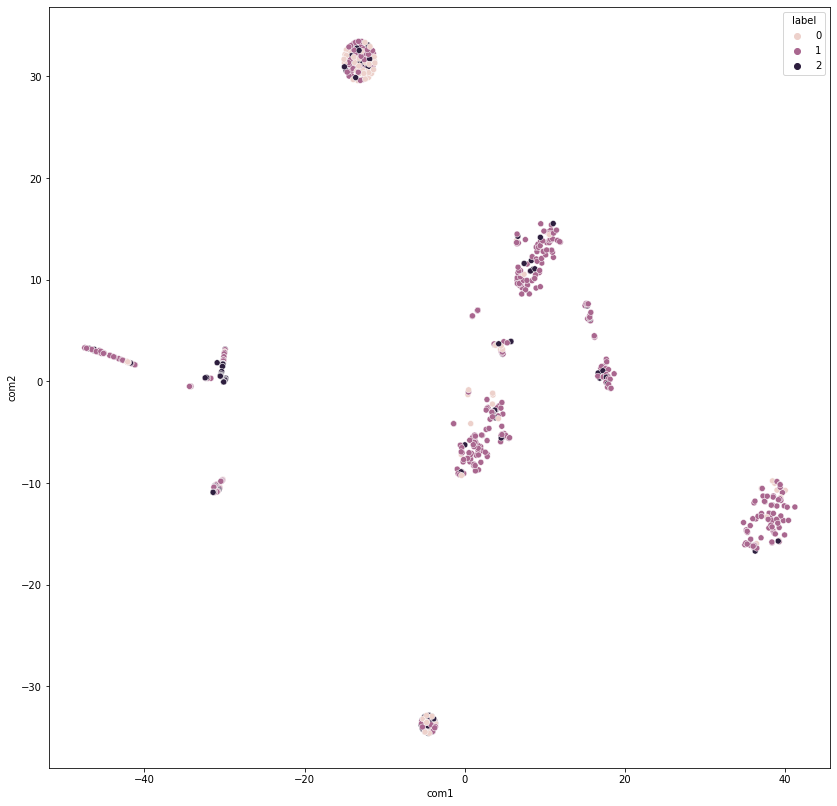

In [ ]:
from sklearn.manifold import TSNE

np.random.seed(160)
tsne = TSNE(n_components=2)
tt = tsne.fit_transform(X)

tt_df = pd.DataFrame(tt, columns=['com1', 'com2'])
tt_df['label'] = y

sns.set_palette('deep')
plt.figure(figsize=(14,14))
sns.scatterplot(x='com1', y='com2', hue='label', data=tt_df)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


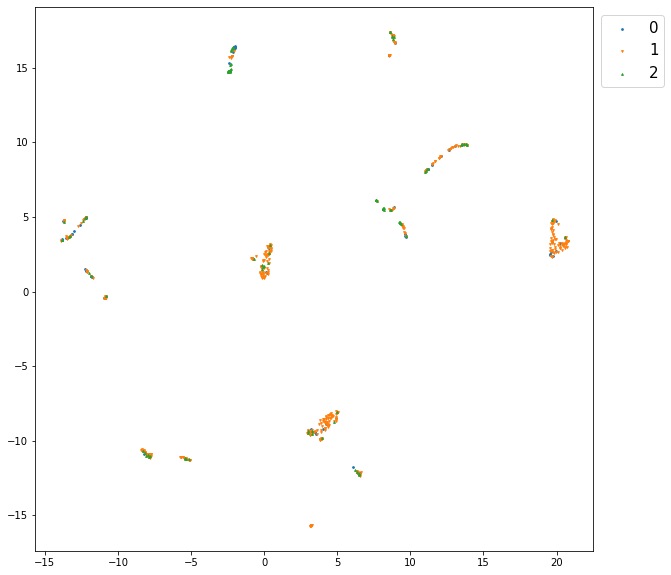

In [ ]:
import umap

um = umap.UMAP()
x_umap = um.fit_transform(X)
markers=['o','v','^']

plt.figure(figsize=(10,10))
for i,marker in enumerate(markers):
    mask = y == i
    plt.scatter(x_umap[mask, 0], x_umap[mask, 1], label=i, s=3, alpha=1,marker=marker)
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left',fontsize=15)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


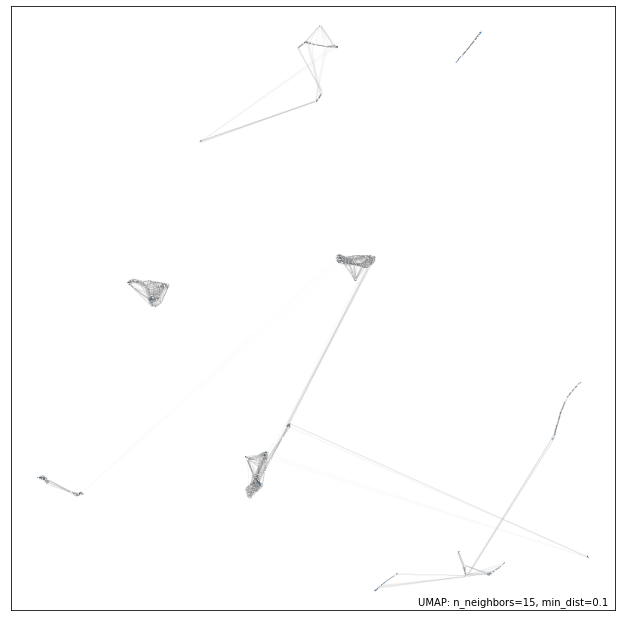

In [ ]:
import umap.plot
mapper = umap.UMAP().fit(X)
umap.plot.connectivity(mapper, show_points=True)

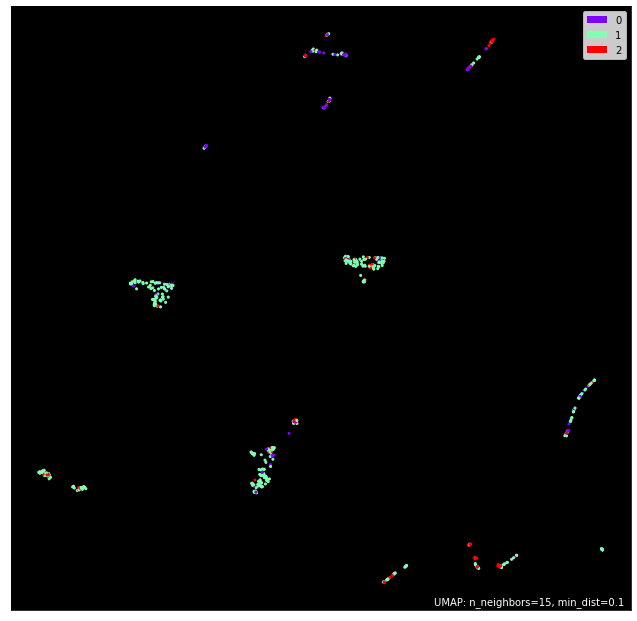

In [ ]:
umap.plot.points(mapper, labels=y, theme='fire')

In [ ]:
import plotly
import plotly.express as px
from umap import UMAP

umap_3d = UMAP(n_components=3, init='random', random_state=0)
x_umap = umap_3d.fit_transform(X)
umap_df = pd.DataFrame(x_umap)
train_y_sr = pd.Series(y,name='label')
print(type(x_umap))
new_df = pd.concat([umap_df,train_y_sr],axis=1)
fig = px.scatter_3d(
    new_df, x=0, y=1, z=2,
    color='label', labels={'color': 'number'}
)
fig.update_traces(marker_size=1)
fig.show()

<class 'numpy.ndarray'>


## 실험

In [ ]:
from sklearn.decomposition import PCA
ex = X.iloc[:, :2]
only_X = X.iloc[:, 2:]
pca = PCA(n_components=10)
pca.fit(only_X)
X_pca = pca.transform(only_X)
print(X_pca.shape)
print(pca.explained_variance_ratio_)

df = pd.DataFrame(X_pca, columns = ['comp1', 'comp2'])
train = pd.concat([df, ex, y], axis=1)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
ex = X.iloc[:, :2]
only_X = X.iloc[:, 2:]

lda = LinearDiscriminantAnalysis()
lda.fit(only_X,y)
X_lda = lda.transform(only_X)


ex_2 = test.iloc[:, :2]
only_X_test = test.iloc[:, 2:]
test_lda = lda.transform(only_X_test)
test = pd.DataFrame(test_lda, columns = ['comp1', 'comp2'])
test = pd.concat([test, ex_2], axis=1)


df = pd.DataFrame(X_lda, columns = ['comp1', 'comp2'])
train = pd.concat([df, ex, y], axis=1)
X = train.drop('Y_Class', axis=1)
y = train['Y_Class']

In [ ]:
# 학습함수 정의 
def objective(trial: Trial, train):
    param = {
        'verbose' : 0,
        'random_state': 7,
        'n_iter_no_change' : 50,
        'validation_fraction' : 0.1,
        'learning_rate' : 0.1,
        'n_estimators' : trial.suggest_int('n_estimators', 100, 2000, step=20),
        'min_impurity_decrease' : trial.suggest_float('min_impurity_decrease', 0, 0.2),
        'max_depth' : trial.suggest_int('max_depth', 2, 20),
        'max_features' : trial.suggest_categorical('max_features', ['auto', 'log2']),
        'subsample' : trial.suggest_float('subsample', 0.7, 1.0, step=0.1)
    }
    cv_accuracy = []
    cv = KFold(n_splits = 5)
    n_iter = 0

    for t,v in cv.split(train, train['Y_Quality']):
        train_cv = train.iloc[t]
        val_cv = train.iloc[v]

        X = train_cv.drop('Y_Quality', axis=1)
        y = train_cv['Y_Quality']

        val_X = val_cv.drop('Y_Quality', axis=1)
        val_y = val_cv['Y_Quality']

        model = GradientBoostingRegressor(**param)

        model.fit(X, y)
        score = mean_squared_error(val_y, model.predict(val_X), squared = True)

        cv_accuracy.append(score)
        n_iter += 1

    return np.mean(cv_accuracy)

# create study
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.HyperbandPruner(),
    study_name='GB-Hyperparameter-Tuning'
)

# 학습 
study.optimize(lambda trial: objective(trial,train), 
               n_trials=50)
print('Best trial : score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))

In [ ]:
# SVC(kernel = 'poly)로 stacking이나 활용하자 / split은 0.2 기준 0 나왔음. 
# 할때 범주형 변수 labelencoding 해놨으니 얘네는 빼고 돌려보고 더 좋은 걸로 하자 

# y_class 나뉘는걸 보면 굉장히 민감하게 나뉘는거같은데 pca와 같은 차원축소 기법이 과연 옳을 것인가는 의문
# 이건 해보고 성능 높아지면 쓰고 아니면 안쓰기 

# 공정 데이터이고 각 컬럼이 비식별화되어 함부로 판단하기 힘듦. 
# 결측치로 비어있는 부분은 아마 line이나 product code가 다름에 따라 해당 공정이 없는 경우일 것으로 예상됨.
# 이상치 처리는 건들지 말고 결측치는 0으로 두어 모델에 반영되지 않게 하자. 

# line, product 4-1 이랑 5-1 조합 train에선 3 3 이고 test에선 3 1 인데 이거 빼고 아니고 성능 차이 확인 

In [ ]:
GB_model = GradientBoostingClassifier(**study.best_trial.params, random_state = 42, n_iter_no_change = 50, validation_fraction = 0.1, learning_rate = 0.05)
GB_model.fit(X, y)
GB_pred = GB_model.predict(test)
print(pd.DataFrame(GB_pred).value_counts())

sample_submission['Y_Class'] = GB_pred
sample_submission.to_csv('./submit.csv', index=False)

1    261
0     30
2     19
dtype: int64


## 1. XGB

In [ ]:
# 학습함수 정의 
def objective(trial: Trial, train):
    param = {
        'criterion' : 'absolute_error',
        'tree_method' : 'exact',
        'seed': 42, 
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators':trial.suggest_int('n_estimators', 100, 1000),        
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 9),
        'max_depth' : trial.suggest_int('max_depth', 3, 30),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.2, 1.0),
        'min_split_loss' : trial.suggest_loguniform('min_split_loss', 1e-3, 10.0),
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
    }
    cv_accuracy = []
    cv = StratifiedKFold(n_splits = 5)
    n_iter = 0

    for t,v in cv.split(train, train['Y_Class']):
        train_cv = train.iloc[t]
        val_cv = train.iloc[v]

        X = train_cv.drop('Y_Class', axis=1)
        y = train_cv['Y_Class']

        val_X = val_cv.drop('Y_Class', axis=1)
        val_y = val_cv['Y_Class']

        model = XGBClassifier(**param)

        model.fit(X, y)
        score = f1_score(val_y, model.predict(val_X), average = 'macro')

        cv_accuracy.append(score)
        n_iter += 1

    return np.mean(cv_accuracy)


# create study
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.HyperbandPruner(),
    study_name='XGBClassifier-Hyperparameter-Tuning'
)

# 학습 
study.optimize(lambda trial: objective(trial,train), 
               n_trials=50)
print('Best trial : score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))

## 2. LGBM

In [ ]:
# 학습함수 정의 
def objective(trial: Trial, train):

    param = {
        'verbose' : -1,
        'random_state': 7, 
        'n_jobs': -1,
        # 'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
        # 'max_depth' : trial.suggest_int('max_depth', 2, 30),
        # 'n_estimators' : trial.suggest_int('n_estimators', 500, 3000),
        # 'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.3), 
        'learning_rate' : 0.1,
        # 'num_leaves' : trial.suggest_int('num_leaves', 5, 30),
        # 'min_child_samples' : trial.suggest_int('min_child_samples', 2, 10),
        # 'reg_alpha' : trial.suggest_float('reg_alpha', 1, 1.3),
        # 'reg_lambda' : trial.suggest_float('reg_lambda', 1, 1.3)
    }
    cv_accuracy = []
    cv = StratifiedKFold(n_splits = 5)
    n_iter = 0

    for t,v in cv.split(train, train['Y_Class']):
        train_cv = train.iloc[t]
        val_cv = train.iloc[v]

        X = train_cv.drop('Y_Class', axis=1)
        y = train_cv['Y_Class']

        val_X = val_cv.drop('Y_Class', axis=1)
        val_y = val_cv['Y_Class']

        model = LGBMClassifier(**param)

        model.fit(X, y)
        score = f1_score(val_y, model.predict(val_X), average = 'macro')
        print(score)

        cv_accuracy.append(score)
        n_iter += 1

    return np.mean(cv_accuracy)

# create study
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.HyperbandPruner(),
    study_name='LGBM-Hyperparameter-Tuning'
)

# 학습 
study.optimize(lambda trial: objective(trial,train),
               n_trials=100)
print('Best trial : score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, stratify = y, random_state = 7)

In [ ]:
from sklearn.feature_selection import f_regression, SelectKBest

## selctor 정의하기
selector = SelectKBest(score_func=f_regression, k=1000)

## 학습데이터에 fit_transform 
X_train_selected = selector.fit_transform(X_train, y_train)

## 테스트 데이터는 transform
X_val_selected = selector.transform(X_val)
X_train_selected.shape, X_val_selected.shape
all_names = X_train.columns

## selector.get_support()
selected_mask = selector.get_support()
## 선택된 특성(변수)들
selected_names = all_names[selected_mask]
## 선택되지 않은 특성(변수)들
unselected_names = all_names[~selected_mask]
print('Selected names: ', selected_names)
print('Unselected names: ', unselected_names)

X = X[list(selected_names)]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, stratify = y, random_state = 7)

model = RandomForestClassifier(random_state=7).fit(X_train, y_train)
pred = model.predict(X_val)
score = f1_score(y_val, pred, average='macro')
print(score)

# feature importance
def plotImp(model, X , num = 200, fig_size = (15, 50)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features')
    plt.tight_layout()
    plt.show()

plotImp(model, X)

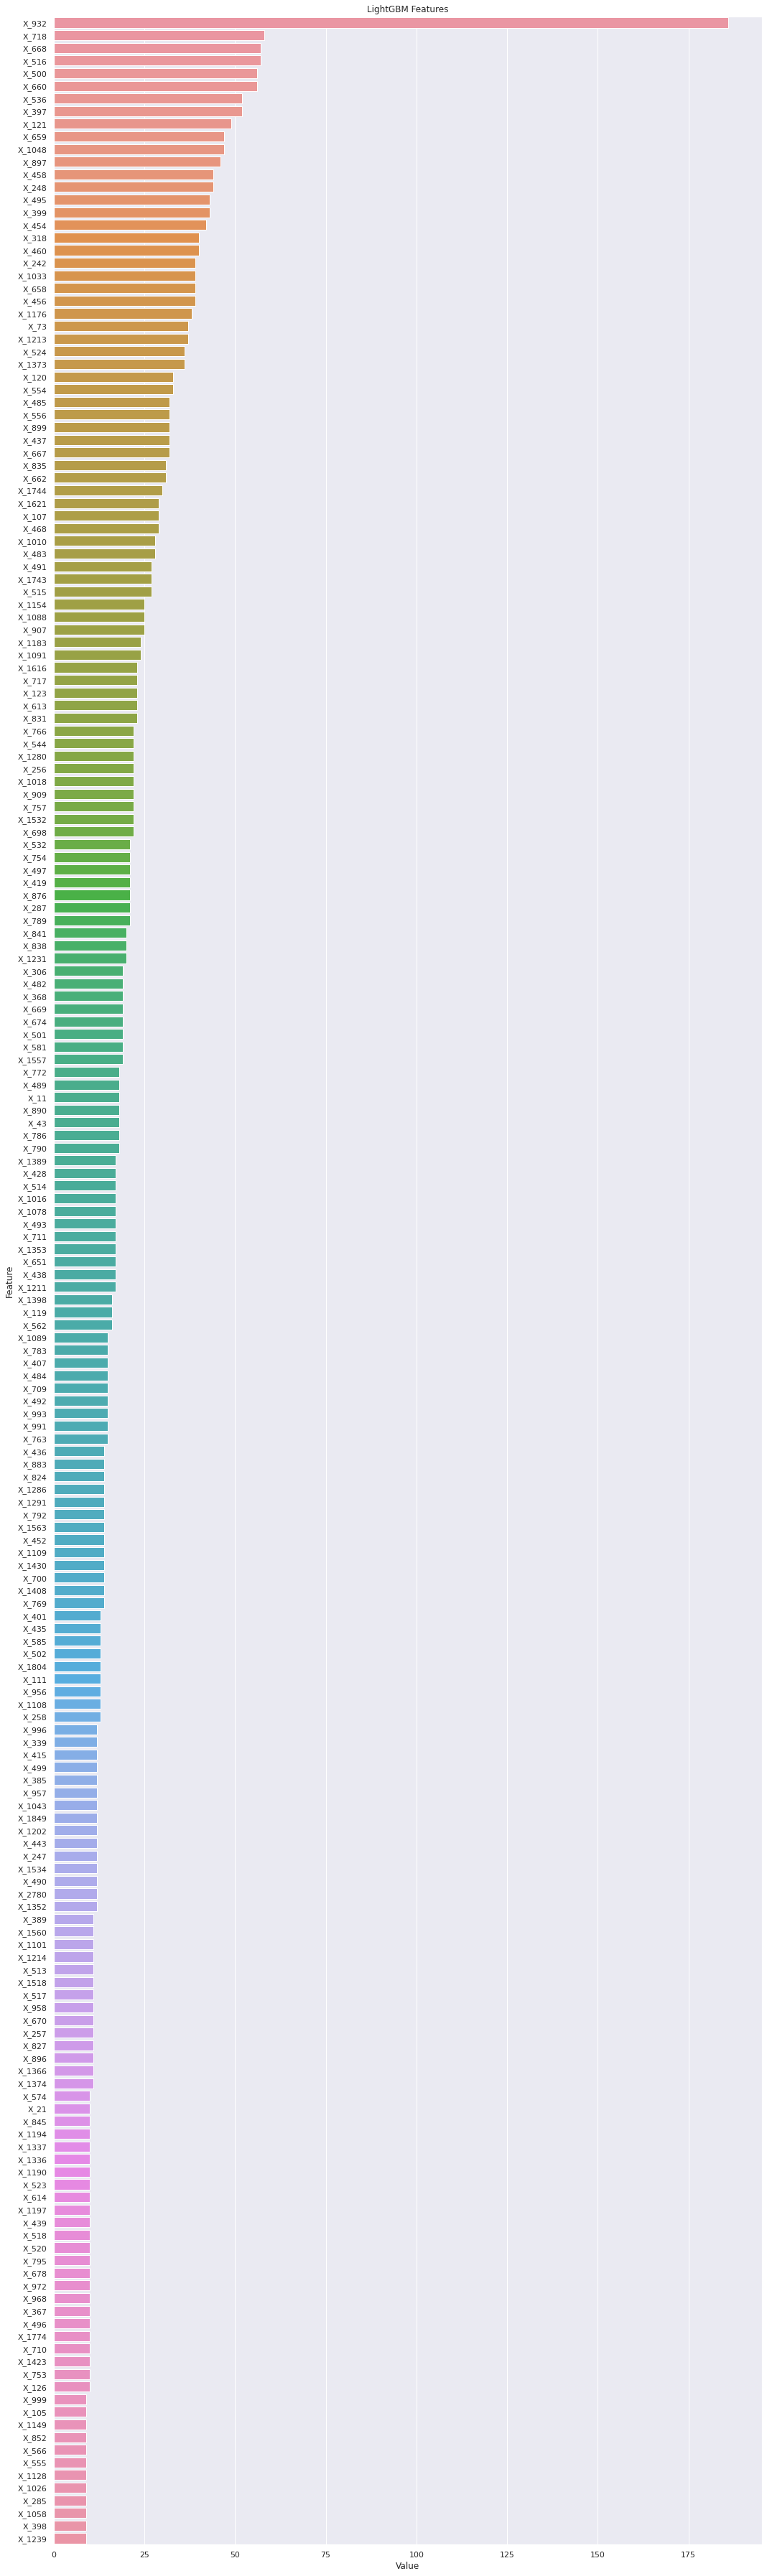

In [ ]:
model = LGBMClassifier(random_state=7).fit(X_train, y_train)
pred = model.predict(X_val)
score = f1_score(y_val, pred, average='macro')
print(score)

# feature importance
def plotImp(model, X , num = 200, fig_size = (15, 50)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features')
    plt.tight_layout()
    plt.show()

plotImp(model, X)

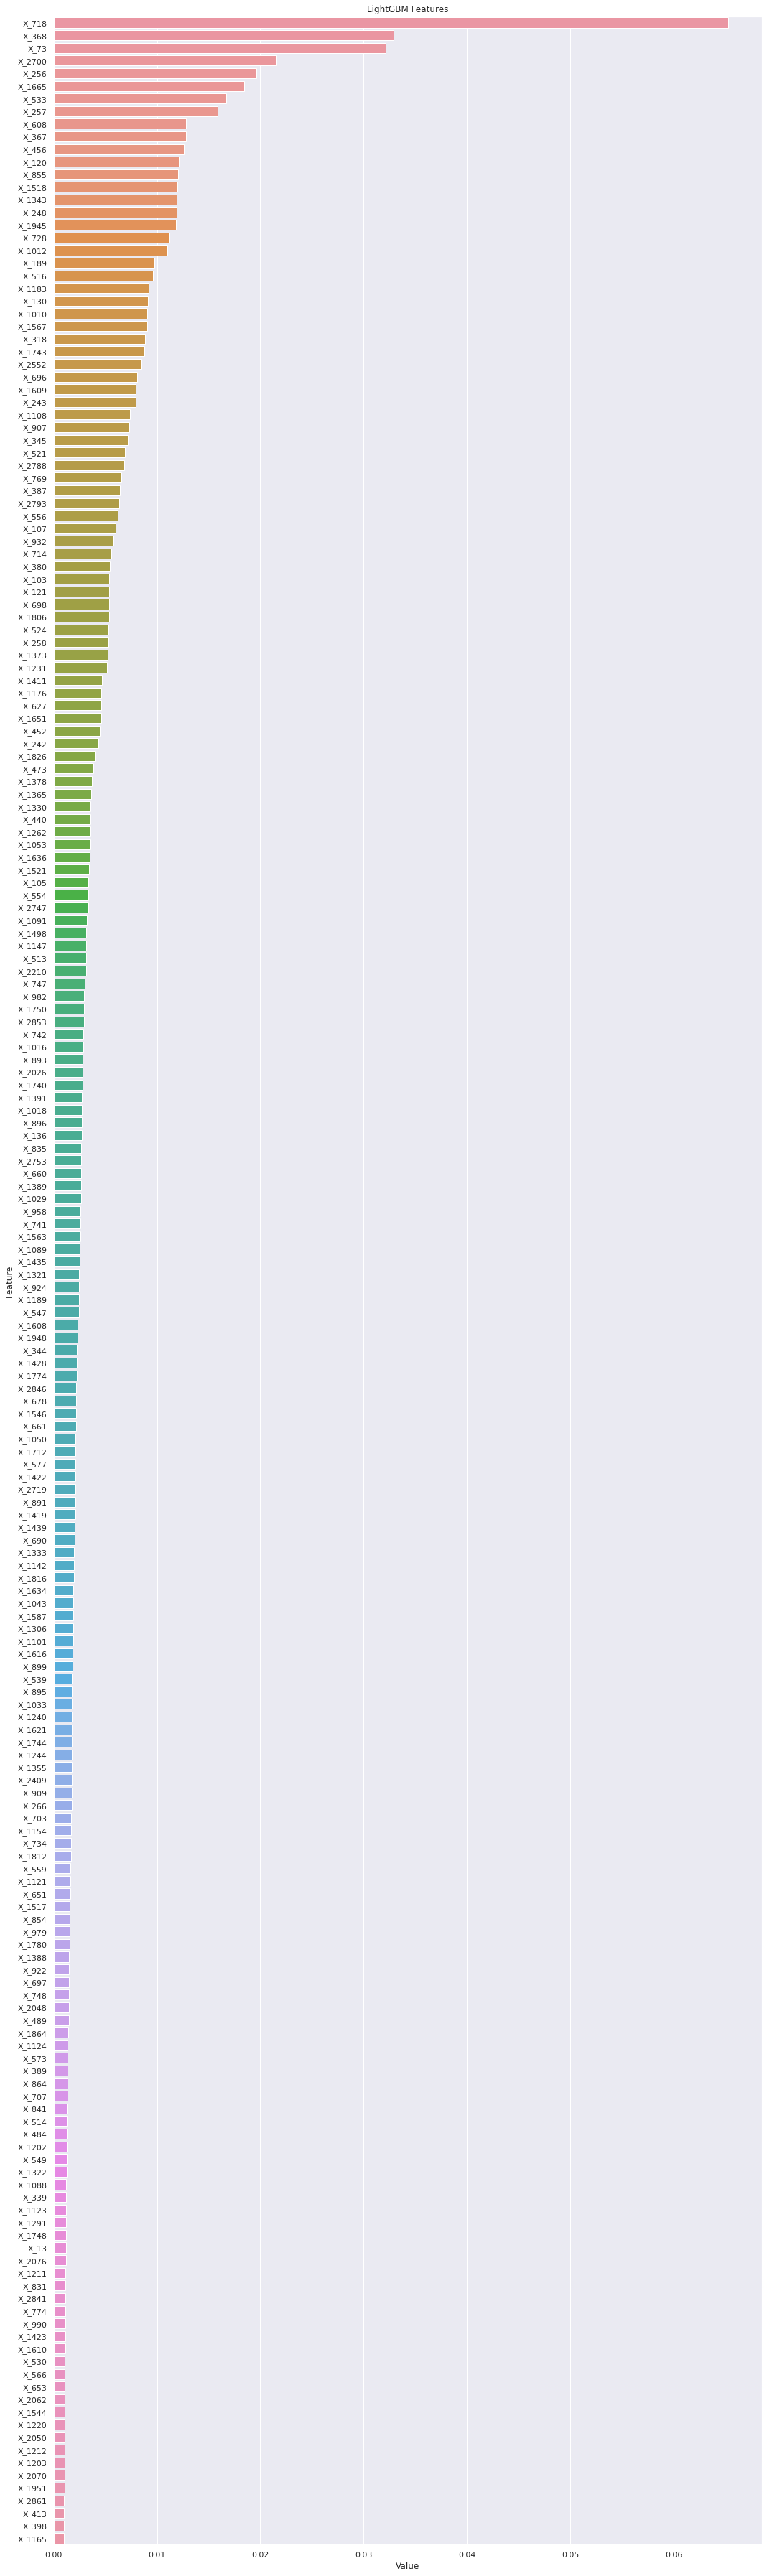

In [ ]:
model = GradientBoostingClassifier(random_state=7).fit(X_train, y_train)
pred = model.predict(X_val)
score = f1_score(y_val, pred, average='macro')
print(score)

# feature importance
def plotImp(model, X , num = 200, fig_size = (15, 50)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features')
    plt.tight_layout()
    plt.show()

plotImp(model, X)

0.7718476903870162


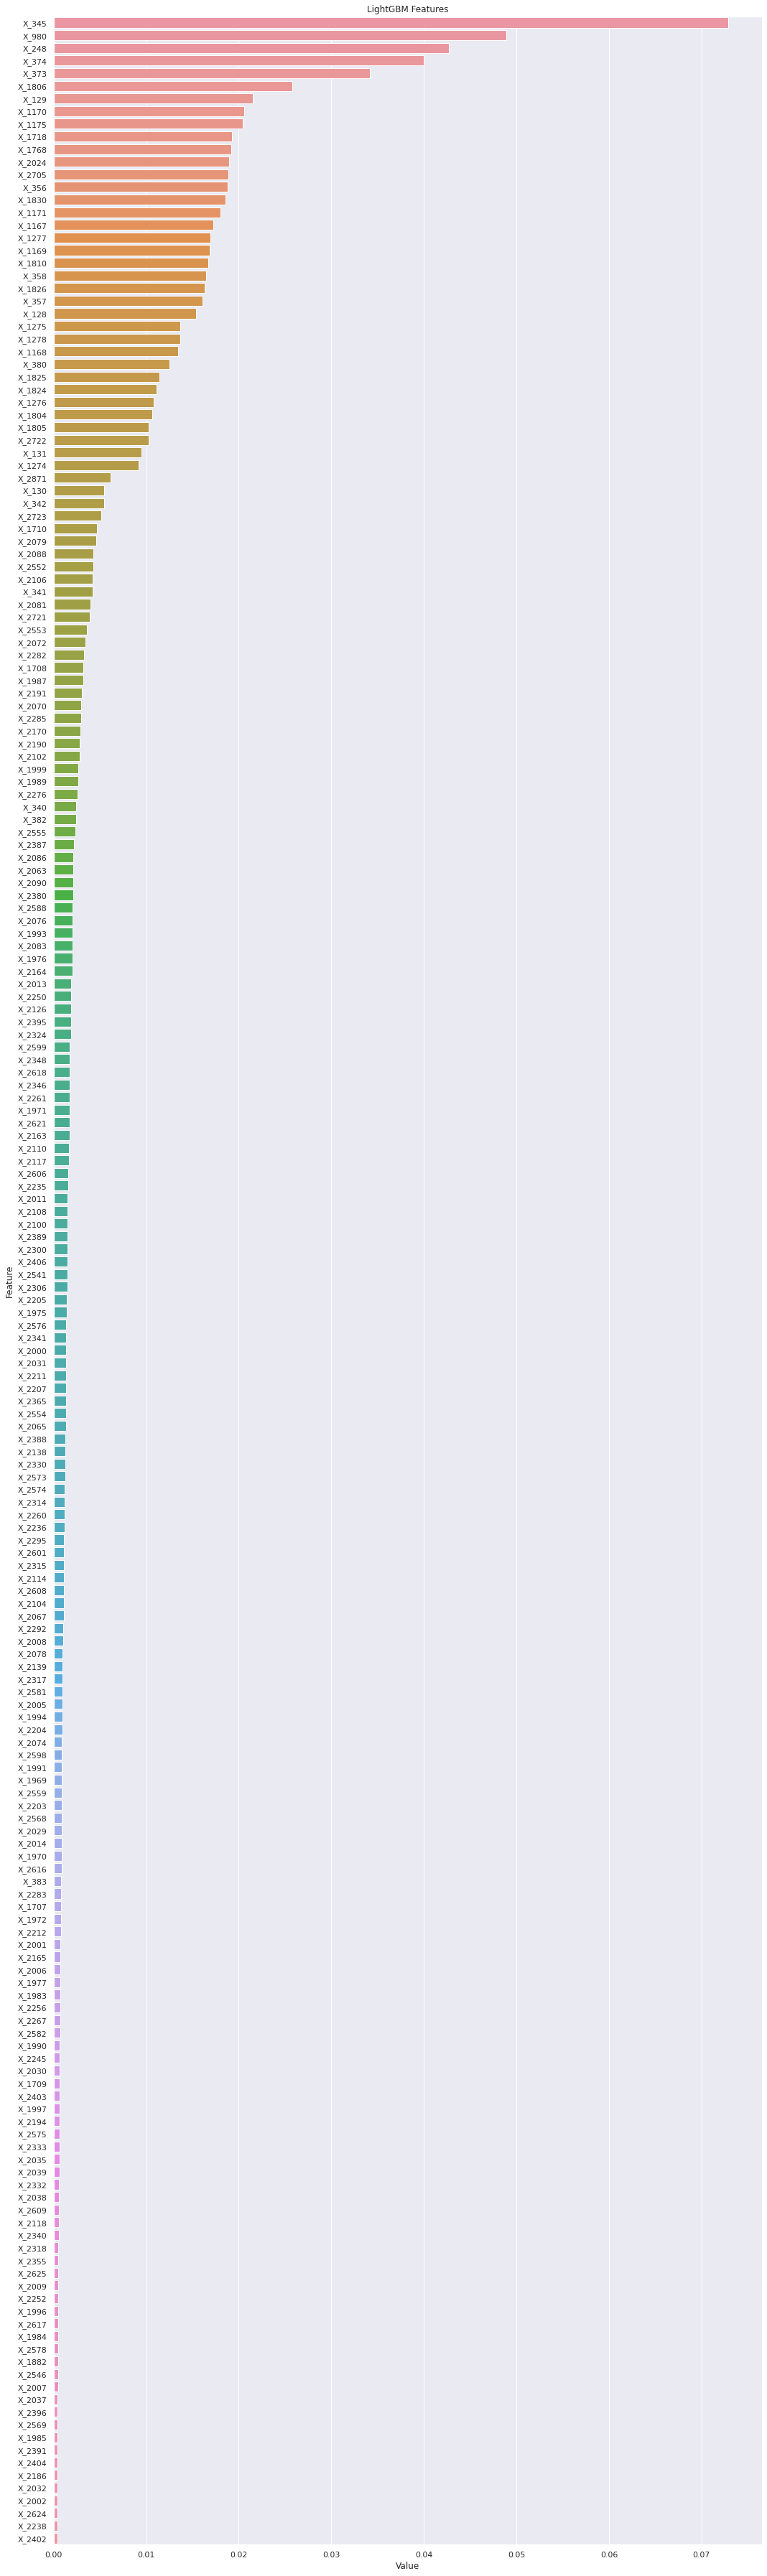

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, stratify = y, random_state = 7)

model = RandomForestClassifier(random_state=7).fit(X_train, y_train)
pred = model.predict(X_val)
score = f1_score(y_val, pred, average='macro')
print(score)

# feature importance
def plotImp(model, X , num = 200, fig_size = (15, 50)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features')
    plt.tight_layout()
    plt.show()

plotImp(model, X)

0.7171724075086569


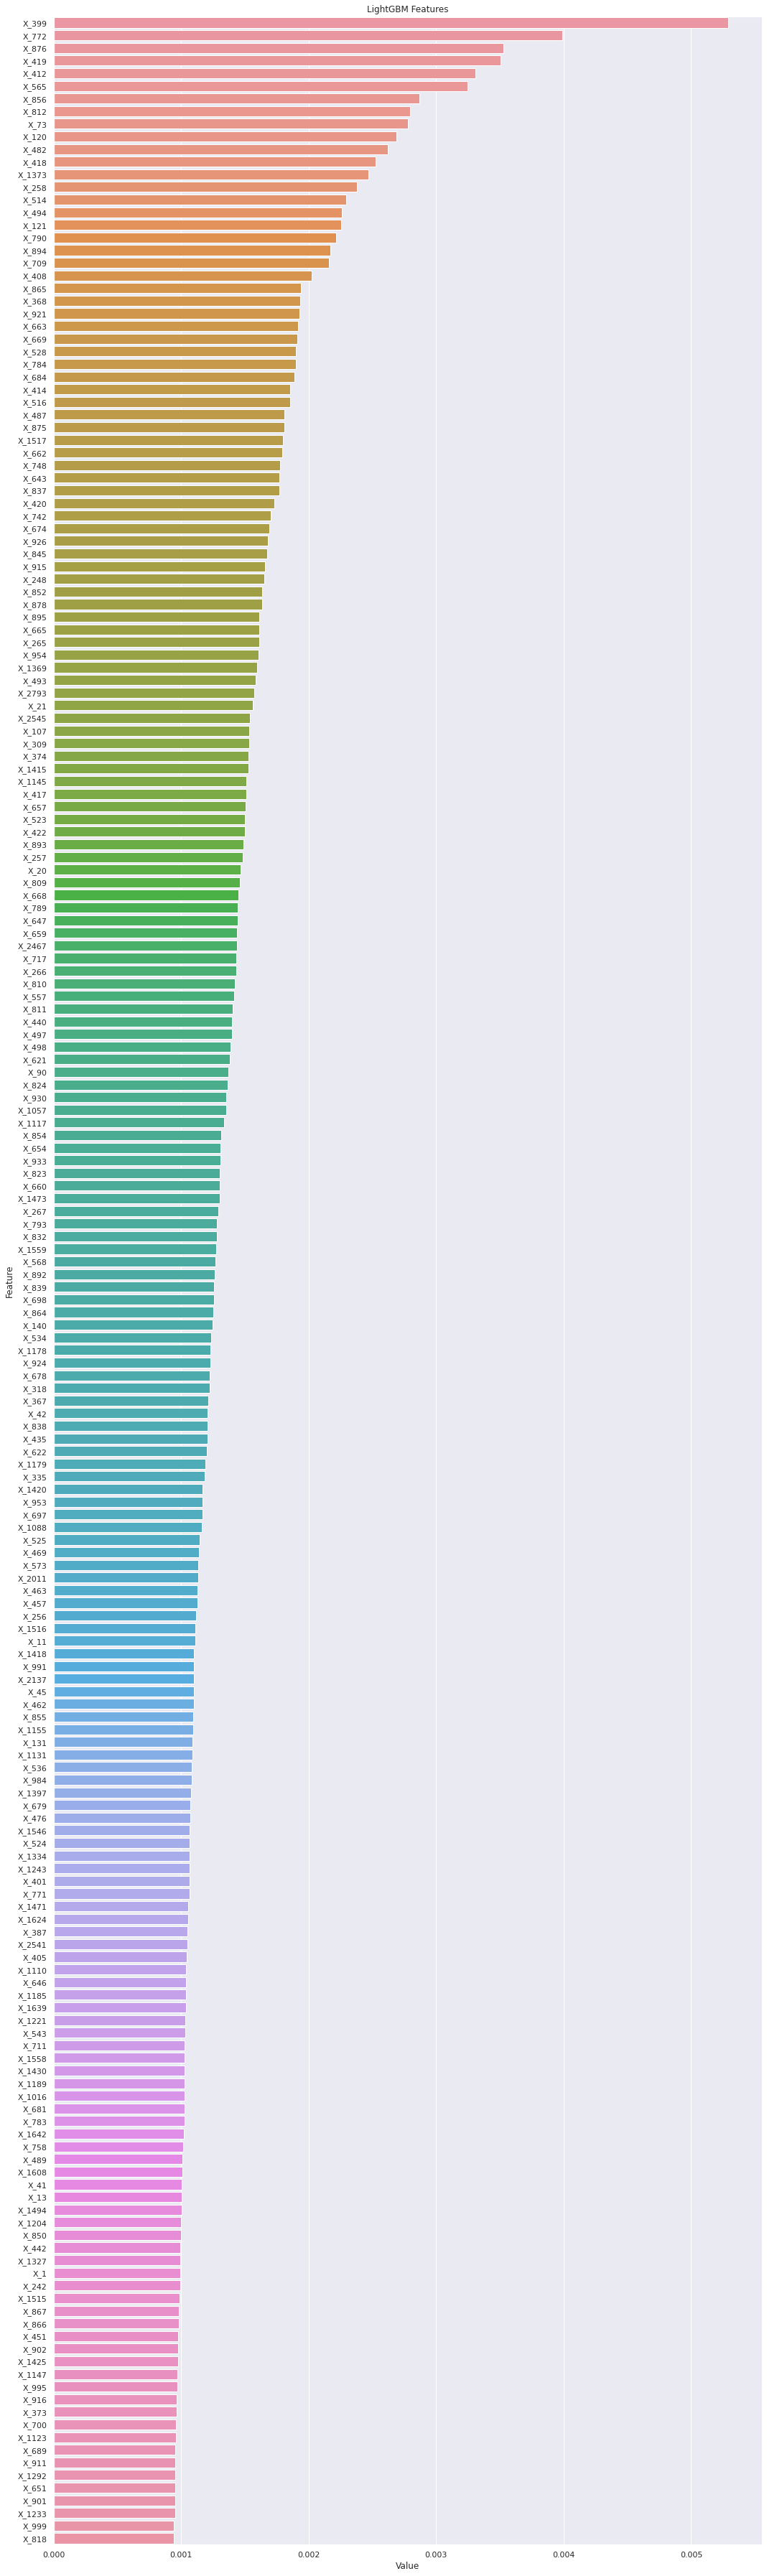

In [ ]:
model = ExtraTreesClassifier(random_state=7).fit(X_train, y_train)
pred = model.predict(X_val)
score = f1_score(y_val, pred, average='macro')
print(score)

# feature importance
def plotImp(model, X , num = 200, fig_size = (15, 50)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features')
    plt.tight_layout()
    plt.show()

plotImp(model, X)

0.7078563411896747


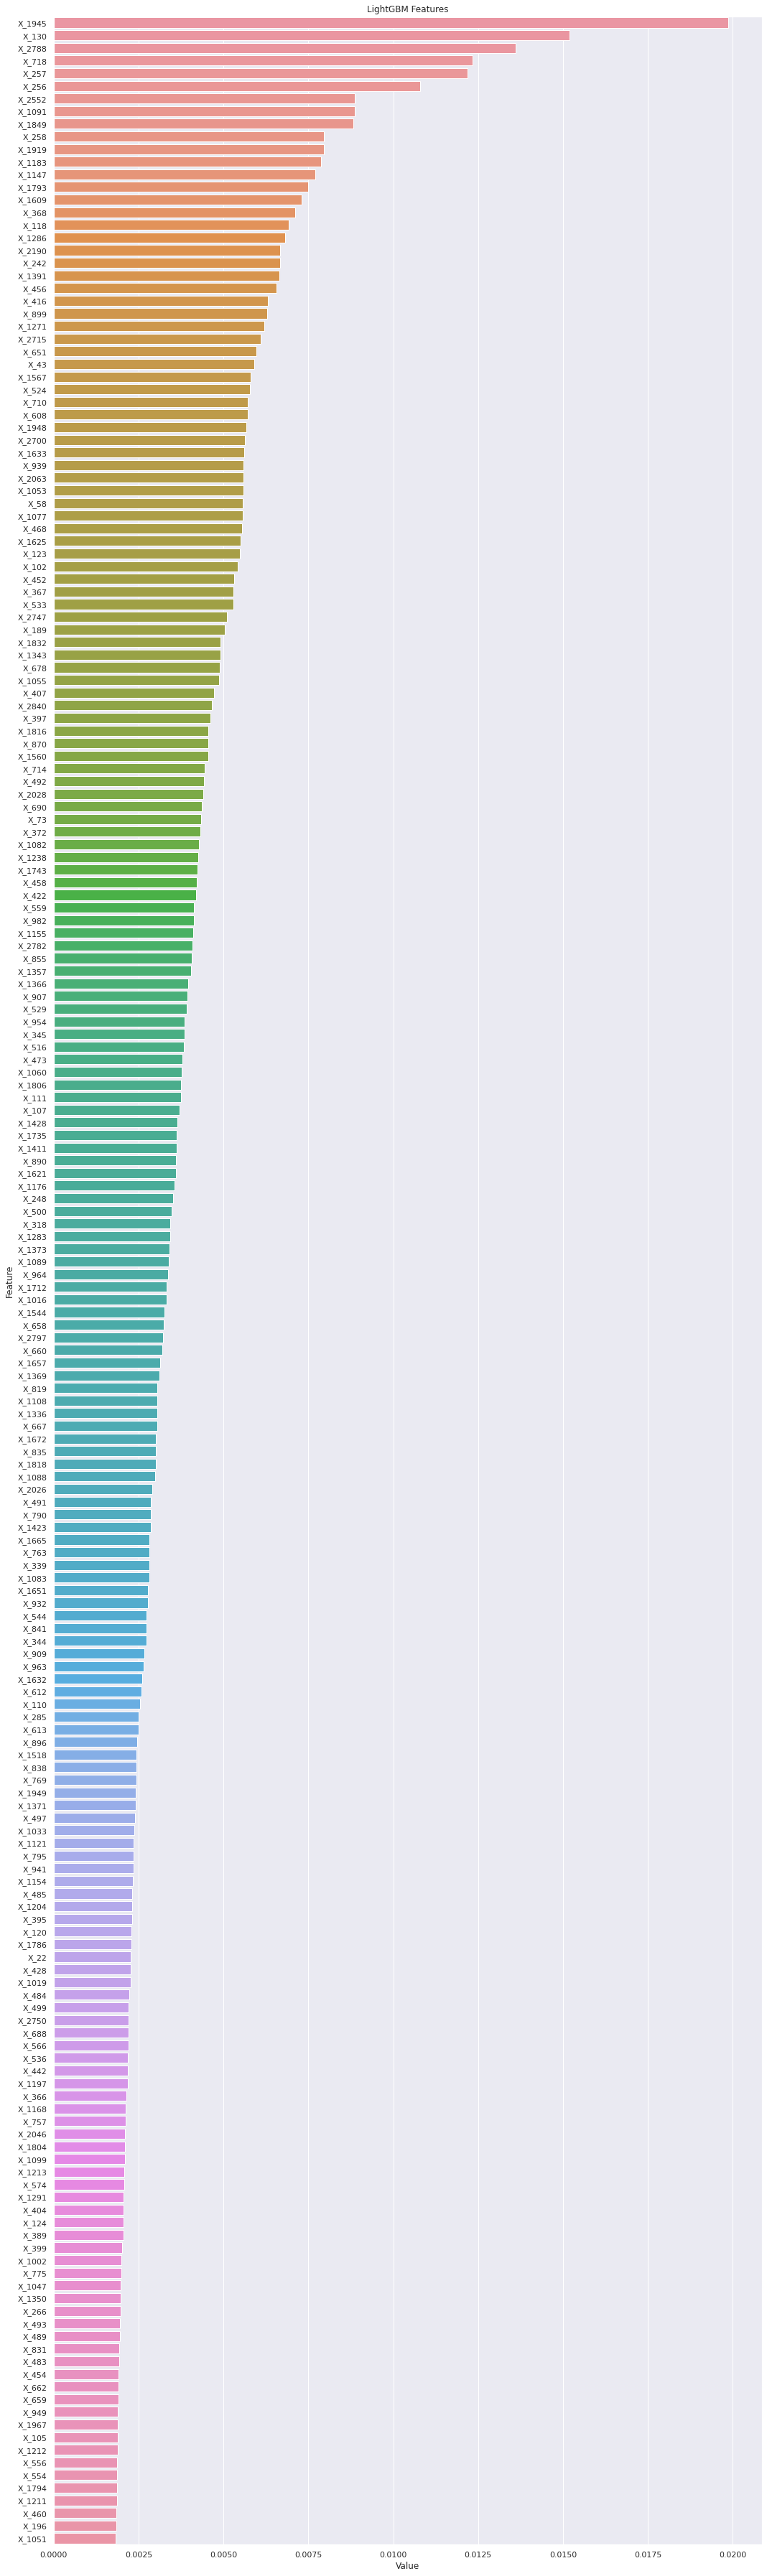

In [ ]:
model = XGBClassifier(random_state=7).fit(X_train, y_train)
pred = model.predict(X_val)
score = f1_score(y_val, pred, average='macro')
print(score)

# feature importance
def plotImp(model, X , num = 200, fig_size = (15, 50)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features')
    plt.tight_layout()
    plt.show()

plotImp(model, X)

In [ ]:
RF = RandomForestClassifier(random_state=43).fit(X, y)
RF_pred = RF.predict(test)

XGB = XGBClassifier(random_state=43).fit(X, y)
XGB_pred = XGB.predict(test)

LGBM = LGBMClassifier(random_state=43).fit(X, y)
LGBM_pred = LGBM.predict(test)

ET = ExtraTreesClassifier(random_state=43).fit(X, y)
ET_pred = ET.predict(test)

GB = GradientBoostingClassifier(random_state=43).fit(X, y)
GB_pred = GB.predict(test)

# 2랑 5가 멀쩡 

In [ ]:
# 5개 다 쓰는 hard voting
# https://wikidocs.net/42408

def mode(list):
    count = 0
    mode = 0;
    for x in list: 
        if list.count(x) > count:
            count = list.count(x)
            mode = x

    return mode
final_pred = []
for i in range(0, len(RF_pred)):
    final_pred.append(mode([RF_pred[i], XGB_pred[i], LGBM_pred[i], ET_pred[i], GB_pred[i]]))
sample_submission['Y_Class'] = final_pred
sample_submission['Y_Class'].value_counts()

1    268
0     40
2      2
Name: Y_Class, dtype: int64

In [ ]:
def mode(list):
    count = 0
    mode = 0;
    for x in list: 
        if list.count(x) > count:
            count = list.count(x)
            mode = x
    return mode
final_pred = []
for i in range(0, len(RF_pred)):
    final_pred.append(mode([GB_pred[i]]))
sample_submission['Y_Class'] = final_pred
sample_submission['Y_Class'].value_counts()

1    242
0     39
2     29
Name: Y_Class, dtype: int64

In [ ]:
sample_submission.to_csv('./submit.csv', index=False)

## 3. ET

In [ ]:
# 학습함수 정의 
def objective(trial: Trial, train):
    param = {
        'verbose' : 1,
        'random_state': 42,
        'n_jobs': -1,
        'max_depth' : trial.suggest_int('max_depth', 5, 50),
        'ccp_alpha' : trial.suggest_float('ccp_alpha', 0, 0.3),
        'n_estimators':trial.suggest_int('n_estimators', 500, 3000),
        'min_impurity_decrease' : trial.suggest_float('min_impurity_decrease', 0, 0.5)
    }
    cv_accuracy = []
    cv = StratifiedKFold(n_splits = 5)
    n_iter = 0

    for t,v in cv.split(train, train['Y_Class']):
        train_cv = train.iloc[t]
        val_cv = train.iloc[v]

        X = train_cv.drop('Y_Class', axis=1)
        y = train_cv['Y_Class']

        val_X = val_cv.drop('Y_Class', axis=1)
        val_y = val_cv['Y_Class']

        model = ExtraTreesClassifier(**param)

        model.fit(X, y)
        score = f1_score(val_y, model.predict(val_X), average = 'macro')

        cv_accuracy.append(score)
        n_iter += 1

    return np.mean(cv_accuracy)


# create study
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.HyperbandPruner(),
    study_name='ExtraTrees-Hyperparameter-Tuning'
)

# 학습 
study.optimize(lambda trial: objective(trial,train), 
               n_trials=50)
print('Best trial : score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))

## 4. GB

In [ ]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE

X = X.iloc[:, 2:]

# 모델설정
sm = BorderlineSMOTE(random_state=42)

# train데이터를 넣어 복제함
X_resampled, y_resampled = sm.fit_resample(X, y)

print('After OverSampling, the shape of train_X: {}'.format(X_resampled.shape))

print("After OverSampling, counts of label '2': {}".format(sum(y_resampled==2)))
print("After OverSampling, counts of label '1': {}".format(sum(y_resampled==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_resampled==0)))

train = pd.concat([X_resampled, y_resampled], axis=1)

After OverSampling, the shape of train_X: (1221, 2594)
After OverSampling, counts of label '2': 407
After OverSampling, counts of label '1': 407
After OverSampling, counts of label '0': 407


In [ ]:
# 학습함수 정의 
def objective(trial: Trial, train):
    param = {
        'n_estimators' : trial.suggest_int('n_estimators', 100, 2000, step=20),
        'min_impurity_decrease' : trial.suggest_float('min_impurity_decrease', 0, 0.2),
        'max_depth' : trial.suggest_int('max_depth', 2, 20),
        'subsample' : trial.suggest_float('subsample', 0.7, 1.0, step=0.1)
    }
    cv_accuracy = []
    cv = StratifiedKFold(n_splits = 5)
    n_iter = 0

    for t,v in cv.split(train, train['Y_Class']):
        train_cv = train.iloc[t]
        val_cv = train.iloc[v]

        X = train_cv.drop('Y_Class', axis=1)
        y = train_cv['Y_Class']

        val_X = val_cv.drop('Y_Class', axis=1)
        val_y = val_cv['Y_Class']

        model = GradientBoostingClassifier(**param, verbose = 0, random_state = 42, n_iter_no_change = 50, validation_fraction = 0.1, learning_rate = 0.1, max_features = 'log2')

        model.fit(X, y)
        score = f1_score(val_y, model.predict(val_X), average = 'macro')

        cv_accuracy.append(score)
        n_iter += 1

    return np.mean(cv_accuracy)

# create study
GB_study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.HyperbandPruner(),
    study_name='GB-Hyperparameter-Tuning'
)

# 학습 
GB_study.optimize(lambda trial: objective(trial,train), 
               n_trials=50)
print('Best trial : score {}, \nparams {}'.format(GB_study.best_trial.value, GB_study.best_trial.params))

[I 2023-02-08 02:38:42,532] A new study created in memory with name: GB-Hyperparameter-Tuning
[I 2023-02-08 02:38:50,398] Trial 0 finished with value: 0.8065440161102696 and parameters: {'n_estimators': 800, 'min_impurity_decrease': 0.19014286128198324, 'max_depth': 15, 'subsample': 0.8999999999999999}. Best is trial 0 with value: 0.8065440161102696.
[I 2023-02-08 02:38:58,300] Trial 1 finished with value: 0.8043449969944445 and parameters: {'n_estimators': 380, 'min_impurity_decrease': 0.031198904067240532, 'max_depth': 3, 'subsample': 1.0}. Best is trial 0 with value: 0.8065440161102696.
[I 2023-02-08 02:39:08,954] Trial 2 finished with value: 0.7954662440902843 and parameters: {'n_estimators': 1240, 'min_impurity_decrease': 0.1416145155592091, 'max_depth': 2, 'subsample': 1.0}. Best is trial 0 with value: 0.8065440161102696.
[I 2023-02-08 02:39:16,367] Trial 3 finished with value: 0.8033546769611786 and parameters: {'n_estimators': 1680, 'min_impurity_decrease': 0.04246782213565523,

Best trial : score 0.8315499549870348, 
params {'n_estimators': 1980, 'min_impurity_decrease': 0.009656594177372678, 'max_depth': 16, 'subsample': 0.7}


In [ ]:
GB_model = GradientBoostingClassifier(**GB_study.best_trial.params, verbose = 0, random_state = 42, n_iter_no_change = 50, validation_fraction = 0.1, learning_rate = 0.05, max_features = 'log2')
GB_model.fit(X_resampled, y_resampled)
GB_pred = GB_model.predict(test)
pd.DataFrame(GB_pred).value_counts()

sample_submission['Y_Class'] = GB_pred
sample_submission.to_csv('./submit.csv', index=False)

1    271
0     34
2      5
dtype: int64